<a href="https://colab.research.google.com/github/Jinzhao-Yu/BioStat615/blob/main/BIOSTAT615_Lecture_10_Fall_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOSTAT615 Lecture 10 - R

## 1. Simulate a Beta distribution

The density function of beta distribution is
$$f(x) = \frac{1}{B(a,b)} x^{a-1} (1-x)^{b-1}, \quad x\in (0,1)$$
Consider $a>1$ and $b>1$.

Using derivative of $f(x)$, we have 
$$f(x) \leq  f\left(\frac{a-1}{a+b-2}\right) $$

In [1]:
#' ar.beta.batch() : accept-reject method for beta(a>1, b>1)
#' @param n - max number of random samples
#' @param a, b - a>1, b>1 parameters for beta distribution
#' @return A list containing the following attributes:
#'    * U - random samples for f(x), regardless of acceptance
#'    * Y - random samples for x, regardless of acceptance
#'    * X - accepted random samples
#'    * R - acceptance ratio
ar.rbeta.batch <- function(n, a, b) {
  md <- dbeta((a-1)/(a+b-2),shape1=a,shape2=b) # upper bound
  U <- runif(n,max=md)    ## simulating y-axis value
  Y <- runif(n)           ## simulate x-axis value (yeah, I know it's confusing)
  idx = which(U < dbeta(Y,a,b)) ## identify where x < f(x) - these values as "accepted"
  count <<- count + 1 ## not necessary; for tracking purpose
  return(list(Y=Y,U=U,idx=idx, X=Y[idx],R =length(idx)/n))
}

Let's draw random samples from $\textrm{Beta}(3,2)$

In [2]:
n = 2000
a = 3
b = 2
count = 0 ## count is a global variable to keep track of function calls

## simulate up to 2,000 points
ar_res = ar.rbeta.batch(n, a, b)

print(ar_res$R) ## print out the acceptance ratio
print(length(ar_res$X)) ## print the number of accepted random samples

[1] 0.564
[1] 1128


and plot it

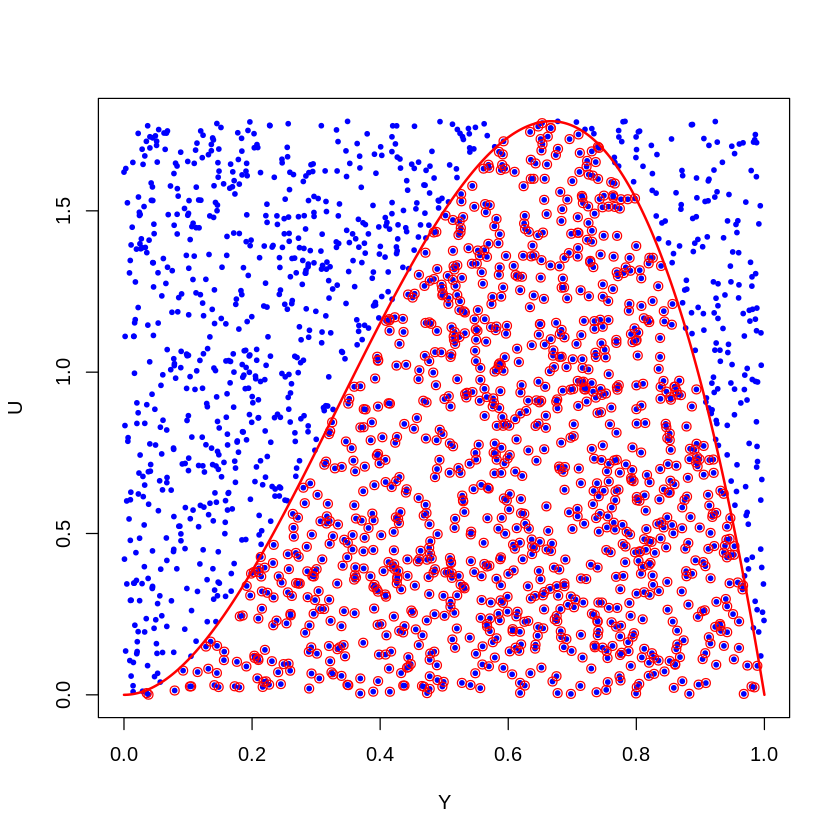

In [3]:
attach(ar_res)
plot(Y,U,col="blue",pch=19,cex=0.5)
points(Y[idx],U[idx],col="red")
x = seq(0,1,length=1000)
lines(x,dbeta(x,a,b),lwd=2,col="red")
detach(ar_res)

Leta compare with $\textrm{Beta}(10,1.5)$

In [4]:
n = 2000
a = 10
b = 1.5
count = 0
ar_res = ar.rbeta.batch(n, a, b)
print(ar_res$R) ## print out the acceptance ratio
print(length(ar_res$X)) ## print the number of accepted random samples

[1] 0.205
[1] 410


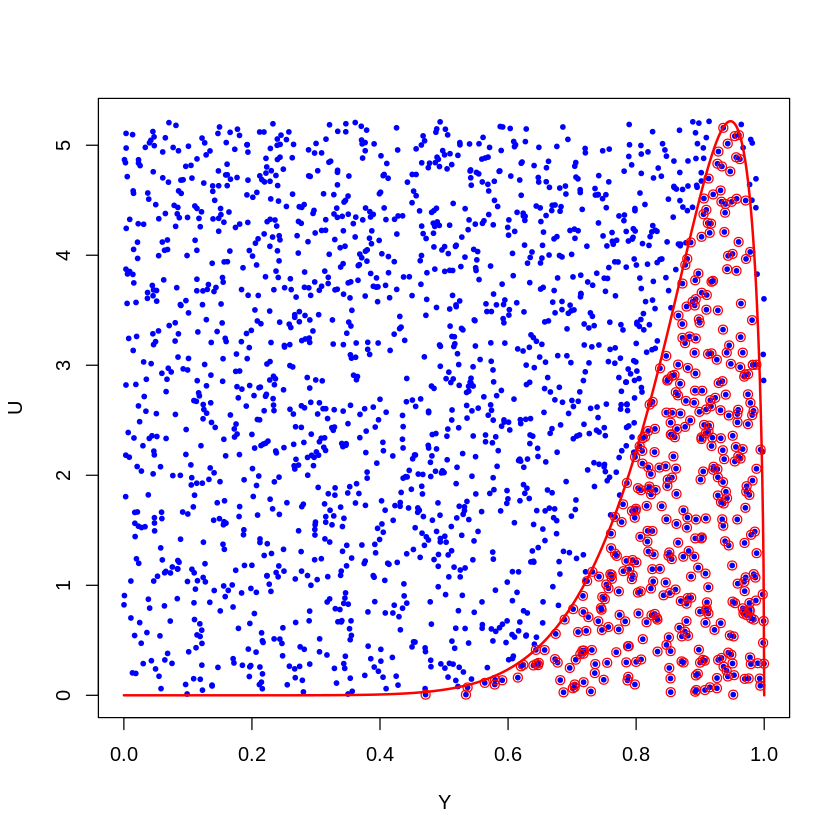

In [5]:
attach(ar_res)
plot(Y,U,col="blue",pch=19,cex=0.5)
points(Y[idx],U[idx],col="red")
x = seq(0,1,length=1000)
lines(x,dbeta(x,a,b),lwd=2,col="red")
detach(ar_res)

## 2. Efficiency of accept-reject sampling

In [6]:
#' ar.beta() : accept-reject method for beta(a>1, b>1)
#' @param m - number of random samples
#' @param a, b - a>1, b>1 parameters for beta distribution
#' @return A vector of m random samples based on accept-reject sampling
ar.rbeta.v1 <- function(m, a, b){
  X = NULL
  while(length(X)<m){ # keep sampling until #samples >= m 
    res = ar.rbeta.batch(m,a,b)
    X = c(X,res$X)    # concatnate random samples
  }
  return(X[1:m])      # return only m samples
}

In [7]:
## reset count - to track the number of ar.rbeta.batch calls
count = 0 

x = ar.rbeta.v1(n,a=10,b=1.5)

print(length(x)) ## print the total number of aceepted samples
print(count)     ## print how many times ar.rbeta.batch() was called

[1] 2000
[1] 6


In [8]:
count = 0
x = ar.rbeta.v1(n,a=50,b=2)
print(count)

[1] 19


## 3. Accept-Reject with Envelope Function

In [9]:
#' accept-reject with target/envelop function
#' @param n - max number of random samples to simulate
#' @return List of Y, U, idx, f, g, M
ar.envelop <- function(n) {
  f <- function(x){  # target
    return(exp(-x^2/2)*(sin(6*x)^2 + 3*cos(x)^2*sin(4*x)^2 + 1))
  }
  g <- function(x) { # envelop - standard normal
    return(exp(-x^2/2))
  }
  M = 5  # f(x) <= Mg(x)

  Y <- rnorm(n) # sample from envelop - standard normal
  U <- runif(n, max=M*g(Y))
  idx = which(U < f(Y))
  return(list(Y=Y,U=U,idx=idx,f=f,g=g,M=M))
}

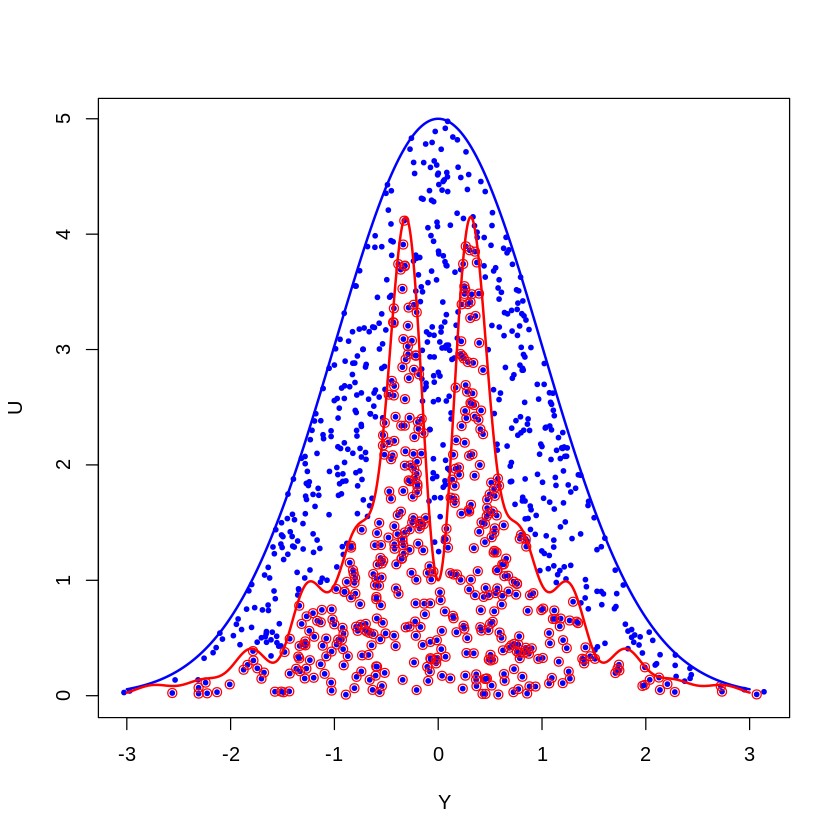

In [10]:
ar_res = ar.envelop(1000)
attach(ar_res)
plot(Y,U,col="blue",pch=19,cex=0.5)
points(Y[idx],U[idx],col="red")
x = seq(-3,3,length=1000)
lines(x,M*g(x),lwd=2,col="blue")
lines(x,f(x),lwd=2,col="red")
detach(ar_res)

## 4. Truncated normal distribution

In [11]:
#' Simulate from truncated Gaussian distribution
#' @param n - number of samples to simulate
#' @param lower - lower bound of samples
#' @return list with X, R (accept ratio), lower 
trunc_norm_1 <- function(n, lower){
  Y = rnorm(n)
  idx = which(Y>lower)
  return(list(X = Y[idx],R = length(idx)/n,lower=lower))
}

In [12]:
#' Simulate from truncated Gaussian distribution
#' @param n - number of samples to simulate
#' @param lower - lower bound of samples
#' @return list with X, R (accept ratio), lower 
trunc_norm_2 <- function(n,lower){
  lambda = (lower+sqrt(lower^2+4))/2 # optimal gamma
  Y = lower + rexp(n,lambda) # sample from exponential
  U = runif(n)  
  log_ratio <- function(x){ 
    return(-log(lambda)-x*x/2+lambda*(x-lower))
  }
  log_M = lambda*lambda/2-lambda*lower-log(lambda)
  idx = which(log(U)<log_ratio(Y)-log_M) # calculate in log space
  return(list(X = Y[idx],R = length(idx)/n,lower=lower))
}

In [13]:
plot_trunc_density <- function(x,lower,main=""){
  if(length(x)>0){
    hist(x,prob=TRUE,main=main)
    s = seq(lower,max(x),length=1000)
    if(pnorm(-lower)>0){
      lines(s,dnorm(s)/pnorm(-lower),lwd=3,col="red")
    } else{
      log_den=dnorm(s,log=TRUE)
      den = exp(log_den - max(log_den))
      den = den/sum(den)/(s[2]-s[1])
      lines(s,den,lwd=3,col="red")
    }
  } else{
    warning("No data points!!")
  }
}

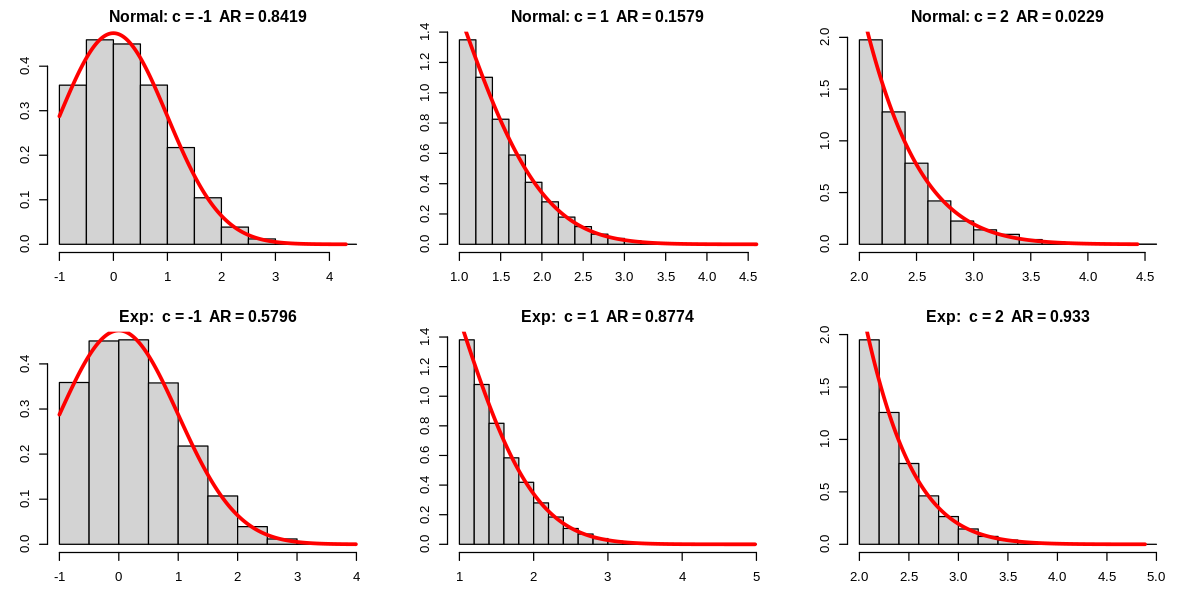

In [14]:
options(repr.plot.width=10, repr.plot.height=5)
N = 100000
par(mfcol=c(2,3),mar=c(3,3,2,2))
for(lower in c(-1,1,2)){
  trunc_res_1 <- trunc_norm_1(N,lower=lower)
  trunc_res_2 <- trunc_norm_2(N,lower=lower)
  with(trunc_res_1,
       plot_trunc_density(X,lower,
                          main=paste("Normal: c =",lower," AR =",
                                     round(R,digits=4))))
  with(trunc_res_2,
       plot_trunc_density(X,lower,
                          main=paste("Exp: ","c =",lower," AR =",
                                     round(R,digits=4))))
}